<a href="https://colab.research.google.com/github/ssyoung26/trajmodelml/blob/main/peerj_traj_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Uncomment and run the below cell the first time the notebook is run.



# Installation and Initializations

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/trajectories/aspirin")
!source /content/drive/MyDrive/venv/bin/activate

In [ ]:
# Used Python 3.10 for this notebook

!pip install torch
!pip install torchvision
!pip install e3nn

# The below helps make the torch_geometric installation go faster

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch_geometric
!pip install seaborn

In [ ]:
# Using file from my Google Drive, data taken from http://www.sgdml.org/#datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import subprocess
import os
import shutil

# Random walk, MCMC, RNN, LSTM
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.optim as optim

# E3NN
import torch_geometric
import e3nn.o3
from e3nn.nn.models.gate_points_2101 import Network
from torchvision import transforms

# Diffusion
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets

# Plot style
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("pastel")

drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/trajectories/aspirin")

# Visualizing molecular trajectories

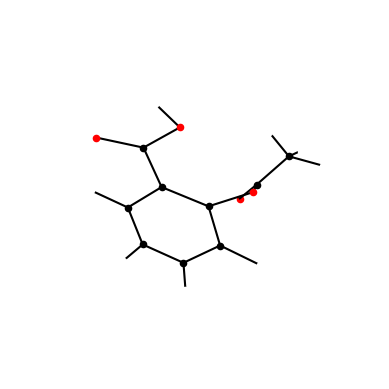

In [ ]:
# Modified function to parse the entire XYZ file
def parse_xyz_multi_frame(filepath):
    with open(filepath, 'r') as file:
        frames = []
        while True:
            line = file.readline()
            if not line:
                break
            num_atoms = int(line.strip())
            file.readline()
            atoms = []
            coordinates = np.zeros((num_atoms, 3))
            for i in range(num_atoms):
                line = file.readline().strip().split()
                atoms.append(line[0])
                coordinates[i] = [float(x) for x in line[1:4]]
            frames.append((atoms, coordinates))
    return frames

def plot_molecule(coordinates, bond_connectivities):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    atom_colors = {'C': 'black', 'O': 'red', 'H': 'white'}

    for i, (atom_type, coord) in enumerate(zip(first_frame_atoms, coordinates)):
        ax.scatter(coord[0], coord[1], coord[2], color=atom_colors[atom_type], label=atom_type if i == 0 else "")

    for atom1, bonded_atoms in bond_connectivities.items():
        for atom2 in bonded_atoms:
            if atom1 < atom2:
                coord1 = coordinates[atom1]
                coord2 = coordinates[atom2]
                ax.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], [coord1[2], coord2[2]], 'k-')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')

    return fig, ax

def animate_traj(frames, covalent_radii, output_file, frame_rate=100, quality=25):
    frames_dir = 'frames'
    os.makedirs(frames_dir, exist_ok=True)

    for frame_index, (frame_atoms, frame_coordinates) in enumerate(frames):
        bond_connectivities = calculate_bond_connectivity(frame_atoms, frame_coordinates, covalent_radii)
        fig, ax = plot_molecule(frame_coordinates, bond_connectivities)
        plt.savefig(f'{frames_dir}/frame_{frame_index:03d}.png')
        plt.close(fig)

    subprocess.run(['ffmpeg', '-r', str(frame_rate), '-i', f'{frames_dir}/frame_%03d.png',
                    '-vcodec', 'libx264', '-crf', str(quality), '-pix_fmt', 'yuv420p', output_file])
    shutil.rmtree(frames_dir)

def calculate_bond_connectivity(atoms, coordinates, covalent_radii, tolerance=0.4):
    bond_connectivities = {i: [] for i in range(len(atoms))}
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            d = np.linalg.norm(coordinates[i] - coordinates[j])
            if d < (covalent_radii.get(atoms[i], 0) + covalent_radii.get(atoms[j], 0) + tolerance):
                bond_connectivities[i].append(j)
                bond_connectivities[j].append(i)
    return bond_connectivities

# Parse the XYZ file to get multiple frames
frames = parse_xyz_multi_frame('aspirin_ccsd-train.xyz')

# Covalent radii for the elements involved in aspirin
covalent_radii = {'C': 0.77, 'H': 0.37, 'O': 0.73}

# Example: Calculate bond connectivity for the first frame and plot the molecule
first_frame_atoms, first_frame_coordinates = frames[0]
bond_connectivities = calculate_bond_connectivity(first_frame_atoms, first_frame_coordinates, covalent_radii)
fig, ax = plot_molecule(first_frame_coordinates, bond_connectivities)
elev, azim = 30, 30
ax.view_init(elev=elev, azim=azim)
plt.draw()
plt.show()

In [ ]:
frames_train = parse_xyz_multi_frame('aspirin_ccsd-train.xyz')
# animate_traj(frames_train, covalent_radii, output_file='molecule_animation_train.mp4')
frames_test = parse_xyz_multi_frame('aspirin_ccsd-test.xyz')
# animate_traj(frames_test, covalent_radii, output_file='molecule_animation_test.mp4')

# Redefining train and test set afterwards, so using this updated code:
combined_frames = frames_train + frames_test
frames_train = combined_frames[:1350]
frames_test = combined_frames[1350:]

# Building a neural net to predict trajectories

The types of models tested
*   Random walk/MCMC
*   Simple NN
*   RNN
*   LSTM
*   GRU
*   E3NN
*   Diffusion Model

# Random Walk/MCMC

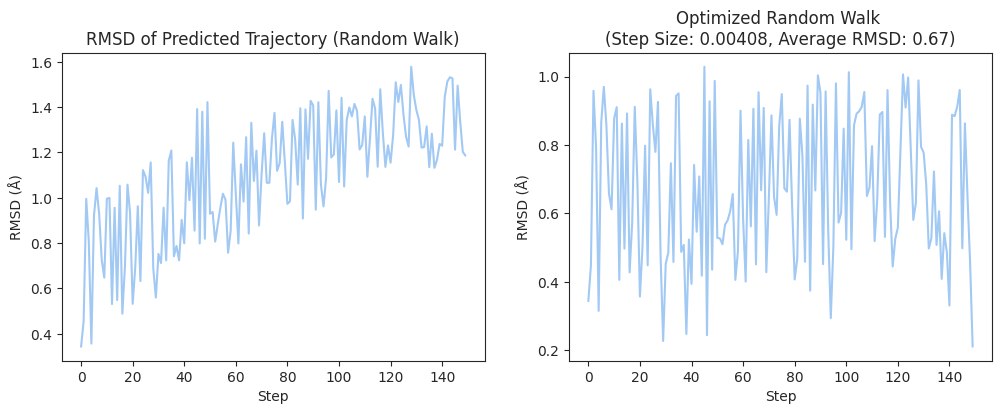

In [ ]:
def random_walk(initial_position, num_steps, step_size):
    trajectory = [initial_position]
    for _ in range(num_steps):
        step = np.random.normal(loc=0, scale=step_size, size=initial_position.shape)
        next_position = trajectory[-1] + step
        trajectory.append(next_position)
    return np.array(trajectory)

def calculate_rmsd(trajectory_predicted, trajectory_actual):
    rmsd_values = []
    for pred, act in zip(trajectory_predicted, trajectory_actual):
        rmsd = np.sqrt(np.mean((pred - act) ** 2))
        rmsd_values.append(rmsd)
    return rmsd_values

initial_position_train = frames_train[0][1]
initial_position_test = frames_test[0][1]

# Perform random walk
num_steps = len(frames_test)
step_size = 0.1
predicted_trajectory = random_walk(initial_position_train, num_steps, step_size)

# Calculate RMSD between the predicted and actual trajectories
actual_trajectory = np.array([frame[1] for frame in frames_test])
rmsd_values = calculate_rmsd(predicted_trajectory, actual_trajectory)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rmsd_values)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title('RMSD of Predicted Trajectory (Random Walk)')

# Optimize the random walk step
step_size_range = np.linspace(0.0001, 0.005, 1000)
best_rmsd = float('inf')
best_step_size = 0

for step_size in step_size_range:
    predicted_trajectory = random_walk(initial_position_train, num_steps, step_size)
    rmsd_values = calculate_rmsd(predicted_trajectory, actual_trajectory)
    final_rmsd = rmsd_values[-1]

    if final_rmsd < best_rmsd:
        best_rmsd = final_rmsd
        best_step_size = step_size

# Perform random walk with best step size
best_predicted_trajectory = random_walk(initial_position_train, num_steps, best_step_size)
best_rmsd_values = calculate_rmsd(best_predicted_trajectory, actual_trajectory)
average_rmsd = np.mean(best_rmsd_values)

# Plot RMSD with best step size
plt.subplot(1, 2, 2)
plt.plot(best_rmsd_values)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'Optimized Random Walk \n(Step Size: {best_step_size:.5f}, Average RMSD: {average_rmsd:.2f})')
plt.show()


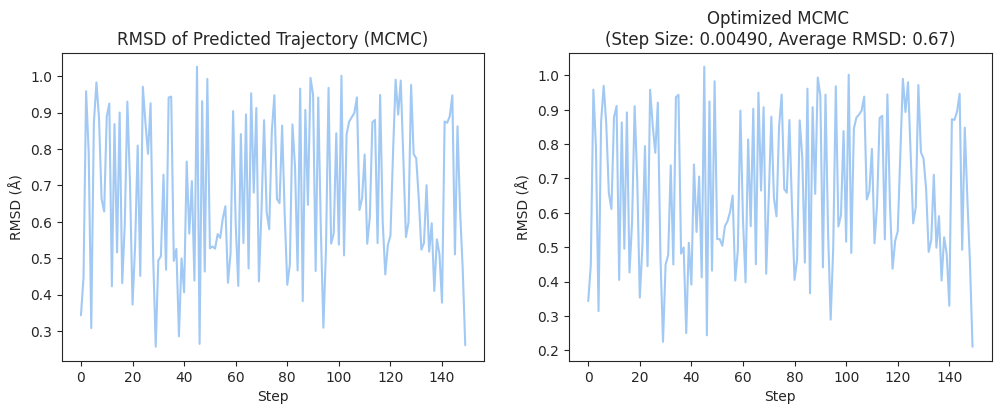

In [ ]:
def mcmc_walk(initial_position, num_steps, step_size, actual_trajectory):
    trajectory = [initial_position]
    current_rmsd = np.sqrt(np.mean((initial_position - actual_trajectory[0]) ** 2))

    for i in range(1, num_steps):
        step = np.random.normal(loc=0, scale=step_size, size=initial_position.shape)
        next_position = trajectory[-1] + step
        next_rmsd = np.sqrt(np.mean((next_position - actual_trajectory[i]) ** 2))

        # Metropolis criterion (accept if RMSD is lower)
        if next_rmsd < current_rmsd:
            trajectory.append(next_position)
            current_rmsd = next_rmsd
        else:
            trajectory.append(trajectory[-1])

    return np.array(trajectory)

def calculate_rmsd(trajectory_predicted, trajectory_actual):
    rmsd_values = []
    for pred, act in zip(trajectory_predicted, trajectory_actual):
        rmsd = np.sqrt(np.mean((pred - act) ** 2))
        rmsd_values.append(rmsd)
    return rmsd_values

initial_position_train = frames_train[0][1]
initial_position_test = frames_test[0][1]

num_steps = len(frames_test)
step_size = 0.1
actual_trajectory = np.array([frame[1] for frame in frames_test])
predicted_trajectory = mcmc_walk(initial_position_train, num_steps, step_size, actual_trajectory)

rmsd_values = calculate_rmsd(predicted_trajectory, actual_trajectory)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rmsd_values)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title('RMSD of Predicted Trajectory (MCMC)')

# Optimize the MCMC step
step_size_range = np.linspace(0.0001, 0.005, 100)
best_rmsd = float('inf')
best_step_size = 0

for step_size in step_size_range:
    predicted_trajectory = mcmc_walk(initial_position_train, num_steps, step_size, actual_trajectory)
    rmsd_values = calculate_rmsd(predicted_trajectory, actual_trajectory)
    final_rmsd = rmsd_values[-1]

    if final_rmsd < best_rmsd:
        best_rmsd = final_rmsd
        best_step_size = step_size

# Perform MCMC walk with the best step size found
best_predicted_trajectory = mcmc_walk(initial_position_train, num_steps, best_step_size, actual_trajectory)
best_rmsd_values = calculate_rmsd(best_predicted_trajectory, actual_trajectory)
average_rmsd = np.mean(best_rmsd_values)

# Plot RMSD for the best step size
plt.subplot(1, 2, 2)
plt.plot(best_rmsd_values)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'Optimized MCMC \n(Step Size: {best_step_size:.5f}, Average RMSD: {average_rmsd:.2f})')
plt.show()

# Simple NN

<ipython-input-7-deb71d9208d3>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_data = torch.tensor([coords.flatten() for _, coords in frames_train], dtype=torch.float32)


Epoch 1, Average Loss: 2.0501
Epoch 2, Average Loss: 2.0119
Epoch 3, Average Loss: 1.9998
Epoch 4, Average Loss: 1.9890
Epoch 5, Average Loss: 1.9846
Epoch 6, Average Loss: 1.9807
Epoch 7, Average Loss: 1.9783
Epoch 8, Average Loss: 1.9770
Epoch 9, Average Loss: 1.9760
Epoch 10, Average Loss: 1.9730
Epoch 11, Average Loss: 1.9721
Epoch 12, Average Loss: 1.9719
Epoch 13, Average Loss: 1.9717
Epoch 14, Average Loss: 1.9716
Epoch 15, Average Loss: 1.9715
Epoch 16, Average Loss: 1.9714
Epoch 17, Average Loss: 1.9713
Epoch 18, Average Loss: 1.9712
Epoch 19, Average Loss: 1.9711
Epoch 20, Average Loss: 1.9711
Epoch 21, Average Loss: 1.9710
Epoch 22, Average Loss: 1.9710
Epoch 23, Average Loss: 1.9710
Epoch 24, Average Loss: 1.9709
Epoch 25, Average Loss: 1.9709
Epoch 26, Average Loss: 1.9709
Epoch 27, Average Loss: 1.9709
Epoch 28, Average Loss: 1.9708
Epoch 29, Average Loss: 1.9708
Epoch 30, Average Loss: 1.9708
Epoch 31, Average Loss: 1.9708
Epoch 32, Average Loss: 1.9708
Epoch 33, Average

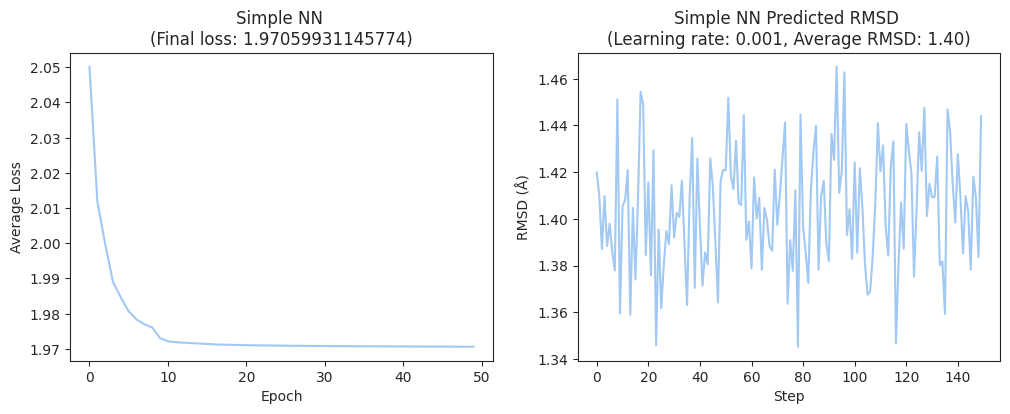

In [ ]:
input_size = frames_train[0][1].flatten().shape[0]
train_data = torch.tensor([coords.flatten() for _, coords in frames_train], dtype=torch.float32)
test_data = torch.tensor([coords.flatten() for _, coords in frames_test], dtype=torch.float32)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, input_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the network
model = SimpleNN(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
average_loss = []
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_data:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_data)
    average_loss.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')  # uncomment this to print losses

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(average_loss)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'Simple NN \n(Final loss: {average_loss[-1]})')

# Predict the test frame coordinates
with torch.no_grad():
    predicted_test_data = model(test_data)

# Calculate RMSD between the predicted and actual test trajectories
def calculate_rmsd(trajectory_predicted, trajectory_actual):
    rmsd_values = []
    for pred, act in zip(trajectory_predicted, trajectory_actual):
        rmsd = np.sqrt(np.mean((pred - act) ** 2))
        rmsd_values.append(rmsd)
    return rmsd_values

predicted_test_coords = predicted_test_data.numpy()
actual_test_coords = test_data.numpy()
rmsd_values_test = calculate_rmsd(predicted_test_coords, actual_test_coords)
average_rmsd_simple_nn = np.mean(rmsd_values_test)

# Plot RMSD for test data
plt.subplot(1, 2, 2)
plt.plot(rmsd_values_test)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'Simple NN Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {average_rmsd_simple_nn:.2f})')
plt.show()

# RNN

Epoch 1, Average Loss: 0.2991
Epoch 2, Average Loss: 0.2831
Epoch 3, Average Loss: 0.2828
Epoch 4, Average Loss: 0.2829
Epoch 5, Average Loss: 0.2827
Epoch 6, Average Loss: 0.2828
Epoch 7, Average Loss: 0.2825
Epoch 8, Average Loss: 0.2825
Epoch 9, Average Loss: 0.2827
Epoch 10, Average Loss: 0.2824
Epoch 11, Average Loss: 0.2827
Epoch 12, Average Loss: 0.2827
Epoch 13, Average Loss: 0.2826
Epoch 14, Average Loss: 0.2829
Epoch 15, Average Loss: 0.2833
Epoch 16, Average Loss: 0.2824
Epoch 17, Average Loss: 0.2831
Epoch 18, Average Loss: 0.2829
Epoch 19, Average Loss: 0.2830
Epoch 20, Average Loss: 0.2835
Epoch 21, Average Loss: 0.2834
Epoch 22, Average Loss: 0.2836
Epoch 23, Average Loss: 0.2836
Epoch 24, Average Loss: 0.2835
Epoch 25, Average Loss: 0.2836
Epoch 26, Average Loss: 0.2836
Epoch 27, Average Loss: 0.2834
Epoch 28, Average Loss: 0.2834
Epoch 29, Average Loss: 0.2835
Epoch 30, Average Loss: 0.2835
Epoch 31, Average Loss: 0.2834
Epoch 32, Average Loss: 0.2832
Epoch 33, Average

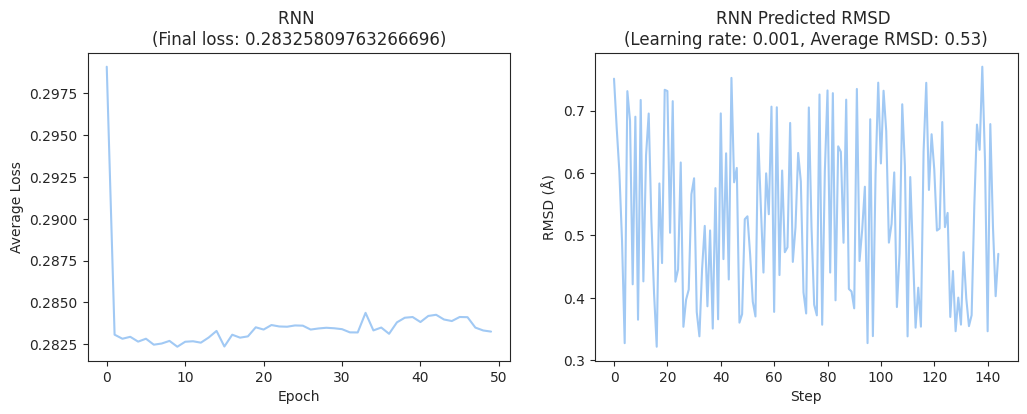

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


sequence_length = 5
train_frames = [coords for _, coords in frames_train]
test_frames = [coords for _, coords in frames_test]
train_frames_tensor = torch.tensor([coords.flatten() for coords in train_frames], dtype=torch.float32)
test_frames_tensor = torch.tensor([coords.flatten() for coords in test_frames], dtype=torch.float32)
train_sequences = [train_frames_tensor[i:i+sequence_length] for i in range(len(train_frames_tensor) - sequence_length)]
train_targets = [train_frames_tensor[i+sequence_length] for i in range(len(train_frames_tensor) - sequence_length)]
test_sequences = [test_frames_tensor[i:i+sequence_length] for i in range(len(test_frames_tensor) - sequence_length)]

# Convert lists to tensors
train_sequences = torch.stack(train_sequences)
train_targets = torch.stack(train_targets)
test_sequences = torch.stack(test_sequences)

# Initialize the RNN
input_size = train_sequences.shape[2]
hidden_size = 128
output_size = input_size
model = RNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(train_sequences)):
        sequence = train_sequences[i].unsqueeze(0)
        target = train_targets[i].unsqueeze(0)
        hidden = model.init_hidden(1)
        optimizer.zero_grad()
        output, _ = model(sequence, hidden)
        loss = criterion(output[:, -1, :], target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_sequences)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}') # uncomment this to print losses

# Plot training losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f"RNN \n(Final loss: {losses[-1]})")

# Prediction on the test set
with torch.no_grad():
    test_predictions = []
    for i in range(len(test_sequences)):
        sequence = test_sequences[i].unsqueeze(0)
        hidden = model.init_hidden(1)
        output, _ = model(sequence, hidden)
        test_predictions.append(output[:, -1, :])

    # Flatten the predictions and the actual data for RMSD calculation
    test_predictions = torch.cat(test_predictions).numpy()
    actual_test_data = test_frames_tensor[sequence_length:].numpy()

# Calculate RMSD
rmsd_test = np.sqrt(np.mean((test_predictions - actual_test_data) ** 2, axis=1))
average_rmsd_rnn = np.mean(rmsd_test)

# Plot RMSD for the test set
plt.subplot(1, 2, 2)
plt.plot(rmsd_test)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'RNN Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {average_rmsd_rnn:.2f})')
plt.show()

# LSTM

Epoch 1, Average Loss: 0.2905
Epoch 2, Average Loss: 0.2680
Epoch 3, Average Loss: 0.2656
Epoch 4, Average Loss: 0.2640
Epoch 5, Average Loss: 0.2629
Epoch 6, Average Loss: 0.2622
Epoch 7, Average Loss: 0.2616
Epoch 8, Average Loss: 0.2611
Epoch 9, Average Loss: 0.2608
Epoch 10, Average Loss: 0.2605
Epoch 11, Average Loss: 0.2603
Epoch 12, Average Loss: 0.2600
Epoch 13, Average Loss: 0.2599
Epoch 14, Average Loss: 0.2597
Epoch 15, Average Loss: 0.2595
Epoch 16, Average Loss: 0.2592
Epoch 17, Average Loss: 0.2589
Epoch 18, Average Loss: 0.2587
Epoch 19, Average Loss: 0.2585
Epoch 20, Average Loss: 0.2583
Epoch 21, Average Loss: 0.2579
Epoch 22, Average Loss: 0.2576
Epoch 23, Average Loss: 0.2572
Epoch 24, Average Loss: 0.2568
Epoch 25, Average Loss: 0.2563
Epoch 26, Average Loss: 0.2558
Epoch 27, Average Loss: 0.2552
Epoch 28, Average Loss: 0.2544
Epoch 29, Average Loss: 0.2538
Epoch 30, Average Loss: 0.2530
Epoch 31, Average Loss: 0.2522
Epoch 32, Average Loss: 0.2513
Epoch 33, Average

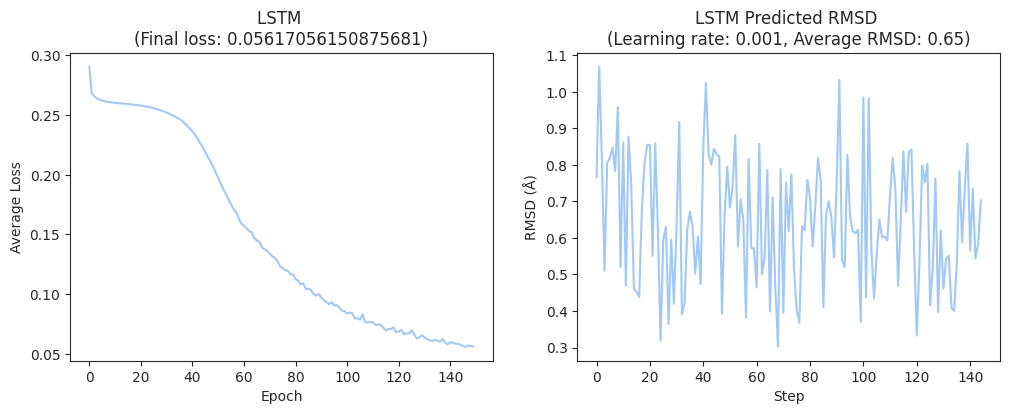

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

sequence_length = 5
train_frames = [coords for _, coords in frames_train]
test_frames = [coords for _, coords in frames_test]
train_frames_tensor = torch.tensor([coords.flatten() for coords in train_frames], dtype=torch.float32)
test_frames_tensor = torch.tensor([coords.flatten() for coords in test_frames], dtype=torch.float32)
train_sequences = [train_frames_tensor[i:i+sequence_length] for i in range(len(train_frames_tensor) - sequence_length)]
train_targets = [train_frames_tensor[i+sequence_length] for i in range(len(train_frames_tensor) - sequence_length)]
test_sequences = [test_frames_tensor[i:i+sequence_length] for i in range(len(test_frames_tensor) - sequence_length)]

# Convert lists to tensors
train_sequences = torch.stack(train_sequences)
train_targets = torch.stack(train_targets)
test_sequences = torch.stack(test_sequences)

# Initialize the LSTM
input_size = train_sequences.shape[2]
hidden_size = 128
output_size = input_size
model = LSTM(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 150
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(train_sequences)):
        sequence = train_sequences[i].unsqueeze(0)
        target = train_targets[i].unsqueeze(0)
        hidden = model.init_hidden(1)
        optimizer.zero_grad()
        output, _ = model(sequence, hidden)
        loss = criterion(output[:, -1, :], target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_sequences)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}') # uncomment this to print losses

# Plot training losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f"LSTM \n(Final loss: {losses[-1]})")

# Prediction on the test set
with torch.no_grad():
    test_predictions = []
    for i in range(len(test_sequences)):
        sequence = test_sequences[i].unsqueeze(0)
        hidden = model.init_hidden(1)
        output, _ = model(sequence, hidden)
        test_predictions.append(output[:, -1, :])

    # Flatten the predictions and the actual data for RMSD calculation
    test_predictions = torch.cat(test_predictions).numpy()
    actual_test_data = test_frames_tensor[sequence_length:].numpy()

# Calculate RMSD
rmsd_test = np.sqrt(np.mean((test_predictions - actual_test_data) ** 2, axis=1))
average_rmsd_lstm = np.mean(rmsd_test)

# Plot RMSD for the test set
plt.subplot(1, 2, 2)
plt.plot(rmsd_test)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'LSTM Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {average_rmsd_lstm:.2f})')
plt.show()

Epoch 1, Average Loss: 0.2931
Epoch 2, Average Loss: 0.2737
Epoch 3, Average Loss: 0.2726
Epoch 4, Average Loss: 0.2707
Epoch 5, Average Loss: 0.2702
Epoch 6, Average Loss: 0.2690
Epoch 7, Average Loss: 0.2678
Epoch 8, Average Loss: 0.2665
Epoch 9, Average Loss: 0.2658
Epoch 10, Average Loss: 0.2654
Epoch 11, Average Loss: 0.2652
Epoch 12, Average Loss: 0.2647
Epoch 13, Average Loss: 0.2642
Epoch 14, Average Loss: 0.2636
Epoch 15, Average Loss: 0.2630
Epoch 16, Average Loss: 0.2626
Epoch 17, Average Loss: 0.2620
Epoch 18, Average Loss: 0.2621
Epoch 19, Average Loss: 0.2612
Epoch 20, Average Loss: 0.2608
Epoch 21, Average Loss: 0.2602
Epoch 22, Average Loss: 0.2599
Epoch 23, Average Loss: 0.2592
Epoch 24, Average Loss: 0.2588
Epoch 25, Average Loss: 0.2580
Epoch 26, Average Loss: 0.2571
Epoch 27, Average Loss: 0.2565
Epoch 28, Average Loss: 0.2559
Epoch 29, Average Loss: 0.2553
Epoch 30, Average Loss: 0.2540
Epoch 31, Average Loss: 0.2532
Epoch 32, Average Loss: 0.2518
Epoch 33, Average

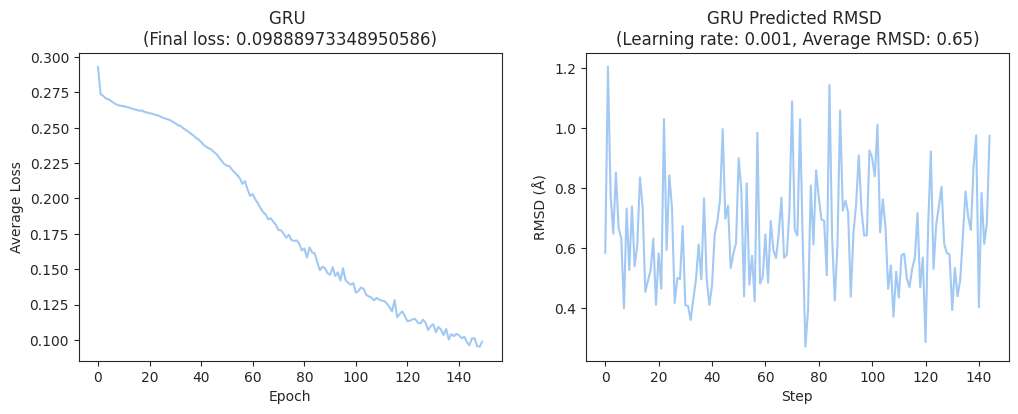

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

model = GRU(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 150
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(train_sequences)):
        sequence = train_sequences[i].unsqueeze(0)
        target = train_targets[i].unsqueeze(0)
        hidden = model.init_hidden(1)
        optimizer.zero_grad()
        output, _ = model(sequence, hidden)
        loss = criterion(output[:, -1, :], target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_sequences)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}') # uncomment this to print losses

# Plot training losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f"GRU \n(Final loss: {losses[-1]})")

# Prediction on the test set
with torch.no_grad():
    test_predictions = []
    for i in range(len(test_sequences)):
        sequence = test_sequences[i].unsqueeze(0)
        hidden = model.init_hidden(1)
        output, _ = model(sequence, hidden)
        test_predictions.append(output[:, -1, :])

    # Flatten the predictions and the actual data for RMSD calculation
    test_predictions = torch.cat(test_predictions).numpy()
    actual_test_data = test_frames_tensor[sequence_length:].numpy()

# Calculate RMSD
rmsd_test = np.sqrt(np.mean((test_predictions - actual_test_data) ** 2, axis=1))
average_rmsd_gru = np.mean(rmsd_test)

# Plot RMSD for the test set
plt.subplot(1, 2, 2)
plt.plot(rmsd_test)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'GRU Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {average_rmsd_gru:.2f})')
plt.show()


# E3NN

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Epoch 1, Average Loss: 66.8676
Epoch 2, Average Loss: 1.4720
Epoch 3, Average Loss: 0.8682
Epoch 4, Average Loss: 0.6003
Epoch 5, Average Loss: 0.4682
Epoch 6, Average Loss: 0.3971
Epoch 7, Average Loss: 0.3561
Epoch 8, Average Loss: 0.3310
Epoch 9, Average Loss: 0.3143
Epoch 10, Average Loss: 0.3027
Epoch 11, Average Loss: 0.2944
Epoch 12, Average Loss: 0.2890
Epoch 13, Average Loss: 0.2850
Epoch 14, Average Loss: 0.2814
Epoch 15, Average Loss: 0.2777
Epoch 16, Average Loss: 0.2748
Epoch 17, Average Loss: 0.2725
Epoch 18, Average Loss: 0.2704
Epoch 19, Average Loss: 0.2685
Epoch 20, Average Loss: 0.2669
Epoch 21, Average Loss: 0.2656
Epoch 22, Average Loss: 0.2644
Epoch 23, Average Loss: 0.2634
Epoch 24, Average Loss: 0.2625
Epoch 25, Average Loss: 0.2616
Epoch 26, Average Loss: 0.2607
Epoch 27, Average Loss: 0.2598
Epoch 28, Average Loss: 0.2590
Epoch 29, Average Loss: 0.2582
Epoch 30, Average Loss: 0.2574
Epoch 31, Average Loss: 0.2566
Epoch 32, Average Loss: 0.2559
Epoch 33, Averag

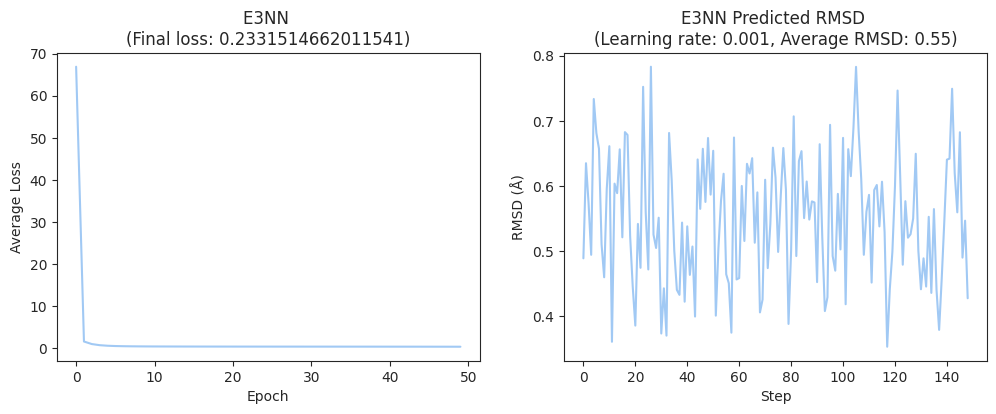

In [ ]:
feat_train = [frame[1] for frame in frames_train[:-1]]
labels_train = [frame[1] for frame in frames_train[1:]]
feat_test = [frame[1] for frame in frames_test[:-1]]
labels_test = [frame[1] for frame in frames_test[1:]]

traj_data_train = [
    torch_geometric.data.Data(
        pos=torch.tensor(frame[1], dtype=torch.float32),
        y=torch.tensor(labels_train[i], dtype=torch.float32)
    )
    for i, frame in enumerate(frames_train[:-1])
]

traj_data_test = [
    torch_geometric.data.Data(
        pos=torch.tensor(frame[1], dtype=torch.float32),
        y=torch.tensor(labels_test[i], dtype=torch.float32)
    )
    for i, frame in enumerate(frames_test[:-1])
]

# Create DataLoaders
train_loader = torch_geometric.loader.DataLoader(traj_data_train, batch_size=1, shuffle=False)
test_loader = torch_geometric.loader.DataLoader(traj_data_test, batch_size=1, shuffle=False)

# Define the e3nn model
model_kwargs = {
    "irreps_in": None,
    "irreps_hidden": e3nn.o3.Irreps("21x0e + 21x1o"),  # Adjusted for 21 atoms
    "irreps_out": "3x0e",
    "irreps_node_attr": None,
    "irreps_edge_attr": e3nn.o3.Irreps.spherical_harmonics(2),
    "layers": 4,
    "max_radius": 5.0,
    "number_of_basis": 15,
    "radial_layers": 2,
    "radial_neurons": 128,
    "num_neighbors": 5,
    "num_nodes": 21,  # Match the number of atoms in aspirin
    "reduce_output": False
}

model = Network(**model_kwargs)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

average_loss = []
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        yhat = model(data)
        loss = criterion(yhat, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    average_loss.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')  # uncomment this to print losses

# Plot training losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(average_loss)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'E3NN \n(Final loss: {average_loss[-1]})')


# Collecting test losses
test_loss = []
test_predictions = []
actual_test_data = []
with torch.no_grad():
    for data in test_loader:
        yhat = model(data)
        loss = criterion(yhat, data.y)
        test_loss.append(loss.item())
        test_predictions.append(yhat.detach().cpu())
        actual_test_data.append(data.y.detach().cpu())
test_predictions = torch.cat(test_predictions, dim=0)
actual_test_data = torch.cat(actual_test_data, dim=0)
num_atoms = 21
train_num_frames = 1349
test_num_frames = 149
test_predictions_reshaped = test_predictions.view(test_num_frames, num_atoms, 3)
actual_test_data_reshaped = actual_test_data.view(test_num_frames, num_atoms, 3)
rmsd_test = torch.sqrt(torch.mean((test_predictions_reshaped - actual_test_data_reshaped) ** 2, axis=(1, 2)))
average_rmsd_e3nn = rmsd_test.mean()

# Plot RMSD for the test set
plt.subplot(1, 2, 2)
plt.plot(rmsd_test)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'E3NN Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {average_rmsd_e3nn:.2f})')
plt.show()

# Trying a Diffusion-based model to predict poses

Diffusion model helper functions.

```process_xyz_to_image``` is a naive implementation to represent each molecule as an "image" which gets passed into the diffusion model. The diffusion model generates new "images" which would also correspond to new molecular poses.
```linear_beta_schedule''' creates an array to use different betas at different timepoints in the diffusion model.
```get_index_from_list''' accesses different frames within the diffusion model.
```forward_diffusion_sample''' deals with the physics of the diffusion model to add noise to an image.
```sample_timestep''' is called during testing to

In [ ]:
IMG_SIZE = 64
T = 300  # Number of timesteps

def process_xyz_to_image(coords, img_size=IMG_SIZE):
    coords_min = coords.min(axis=0)
    coords_max = coords.max(axis=0)
    normalized_coords = (coords - coords_min) / (coords_max - coords_min)
    image = np.zeros((img_size, img_size, 3))
    x_indices = np.clip((normalized_coords[:, 0] * img_size).astype(int), 0, img_size - 1)
    y_indices = np.clip((normalized_coords[:, 1] * img_size).astype(int), 0, img_size - 1)
    for x, y, coord in zip(x_indices, y_indices, normalized_coords):
        image[x, y, :] = coord
    tensor_image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    tensor_image = tensor_image * 2 - 1
    return tensor_image

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    device = vals.device
    out = vals.gather(-1, t.to(device))
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def forward_diffusion_sample(x_0, t, alphas_cumprod, sqrt_one_minus_alphas_cumprod, device):
    noise = torch.randn_like(x_0, device=device)
    sqrt_alphas_cumprod_t = get_index_from_list(alphas_cumprod, t, x_0.shape).sqrt_().to(device)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)
    noisy_image = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy_image, noise


betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

@torch.no_grad()
def sample_timestep(x, t, model, betas, sqrt_one_minus_alphas_cumprod, posterior_variance):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(torch.sqrt(1.0 / (1.0 - betas)), t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

Unet for diffusion model neural net learning

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

Epoch 0 | Avg Loss: 0.084473
Epoch 5 | Avg Loss: 0.003858
Epoch 10 | Avg Loss: 0.002252
Epoch 15 | Avg Loss: 0.008072
Epoch 20 | Avg Loss: 0.001516
Epoch 25 | Avg Loss: 0.001950


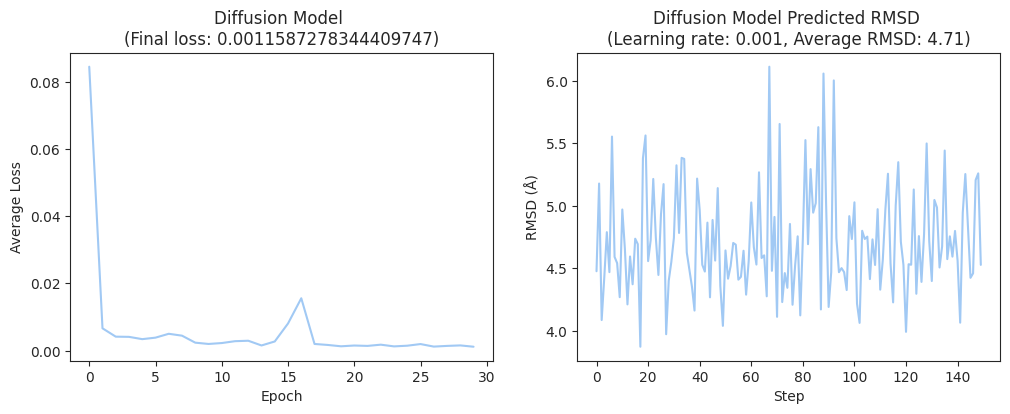

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self, timesteps, model, device):
        super().__init__()
        self.timesteps = timesteps
        self.model = model.to(device)
        self.device = device
        # Betas and alphas_cumprod are pre-calculated and passed to the model
        self.betas = betas.to(device)
        self.alphas_cumprod = alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
        self.posterior_variance = (self.betas * (1. - torch.cat([torch.tensor([1.], device=device), self.alphas_cumprod[:-1]])) / (1. - self.alphas_cumprod)).to(device)

    def forward(self, x, t):
        noise = torch.randn_like(x)
        sqrt_alpha_cumprod_t = get_index_from_list(self.alphas_cumprod, t, x.shape).sqrt_()
        return sqrt_alpha_cumprod_t * x + self.sqrt_one_minus_alphas_cumprod[t] * noise

    def sample(self, num_samples):
        x = torch.randn((num_samples, 3, IMG_SIZE, IMG_SIZE), device=self.device)
        for t in reversed(range(self.timesteps)):
            x = sample_timestep(x, torch.full((num_samples,), t, device=self.device, dtype=torch.long), self.model, self.betas, self.sqrt_one_minus_alphas_cumprod, self.posterior_variance)
        return x

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet()
diffusion_model = DiffusionModel(T, model, device)
optimizer = optim.Adam(diffusion_model.parameters(), lr=0.001)

processed_frames_train = [process_xyz_to_image(frame[1]) for frame in frames_train]
frame_dataset = DataLoader(processed_frames_train, batch_size=3)
losses = []
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in enumerate(frame_dataset):
        optimizer.zero_grad()
        x_0 = batch.to(device)
        t = torch.randint(0, T, (x_0.size(0),), device=device).long()

        # Forward diffusion process
        noisy_image, _ = forward_diffusion_sample(x_0, t, alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)

        # Predict the noise and compute the loss
        noise_pred = diffusion_model.model(noisy_image, t)
        loss = F.mse_loss(noise_pred, noisy_image)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(frame_dataset)
    losses.append(avg_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Avg Loss: {avg_loss:.6f}")

# Plot the training losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'Diffusion Model \n(Final loss: {losses[-1]})')


# Test the model

# Convert the image to xyz
def image_to_xyz(tensor_image, coords_min, coords_max, num_atoms=21):
    image = tensor_image.permute(1, 2, 0).numpy()  # Convert to HxWxC
    image = (image + 1) / 2  # Rescale to [0, 1]

    xyz_coords = []
    atom_count = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if atom_count >= num_atoms:
                break
            # Extract atom coordinates
            x_coord = (i / image.shape[0]) * (coords_max[0] - coords_min[0]) + coords_min[0]
            y_coord = (j / image.shape[1]) * (coords_max[1] - coords_min[1]) + coords_min[1]
            z_coord = image[i, j, 2] * (coords_max[2] - coords_min[2]) + coords_min[2]
            xyz_coords.append([x_coord, y_coord, z_coord])
            atom_count += 1

    return np.array(xyz_coords)

def calculate_rmsd(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2, axis=1))

# Generate frames and calculate RMSD for test set
all_coords = np.concatenate([coords for _, coords in frames_train + frames_test], axis=0)
coords_min = all_coords.min(axis=0)
coords_max = all_coords.max(axis=0)
example_molecule = None
min_rmsd = float('inf')

rmsd_values_per_frame = []
with torch.no_grad():
    for i in range(len(frames_test)):
        # Generate a new frame
        generated_frame = diffusion_model.sample(num_samples=1).squeeze()
        # Convert the generated frame to XYZ
        generated_xyz = image_to_xyz(generated_frame.cpu(), coords_min, coords_max, num_atoms=21)
        # Get the corresponding actual frame
        actual_xyz = np.array(frames_test[i][1])
        # Calculate RMSD
        rmsd = calculate_rmsd(generated_xyz, actual_xyz).mean()  # Taking mean to get single RMSD value per frame
        rmsd_values_per_frame.append(rmsd)
        if rmsd < min_rmsd:
          min_rmsd = rmsd
          example_molecule = generated_xyz

average_rmsd_diffusion = np.mean(rmsd_values_per_frame)
# Plot RMSD values per frame
plt.subplot(1, 2, 2)
plt.plot(rmsd_values_per_frame)
plt.xlabel('Step')
plt.ylabel('RMSD (Å)')
plt.title(f'Diffusion Model Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {average_rmsd_diffusion:.2f})')
plt.show()